In [1]:
# Importing dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df = pd.read_stata("C:\\Users\gmoor\Documents\Applied Microeconomics\Data\cars1.dta")

df.head()

,year,country,co,type,segment,domestic,firm,brand,loc,qu,...,weight,pop,ngdp,ngdpe,country1,country2,country3,country4,country5,yearsquared
0,1983,Belgium,1,alfa 33,compact,0,AlfaRomeo,AlfaRomeo,Italy,729.0,...,890,9860000.0,4.188800e+12,234000000.0,1,0,0,0,0,3932289.0
1,1984,Belgium,1,alfa 33,compact,0,AlfaRomeo,AlfaRomeo,Italy,1860.0,...,890,9860000.0,4.512600e+12,234000000.0,1,0,0,0,0,3936256.0
2,1985,Belgium,1,alfa 33,compact,0,AlfaRomeo,AlfaRomeo,Italy,1771.0,...,890,9860000.0,4.834400e+12,234000000.0,1,0,0,0,0,3940225.0
3,1986,Belgium,1,alfa 33,compact,0,AlfaRomeo,AlfaRomeo,Italy,2047.0,...,890,9860000.0,5.084900e+12,234000000.0,1,0,0,0,0,3944196.0
4,1987,Belgium,1,alfa 33,compact,0,Fiat,AlfaRomeo,Italy,2147.0,...,910,9870000.0,5.318700e+12,234000000.0,1,0,0,0,0,3948169.0


# (a) Summary statistics and correlation between LogPrice and LogQuantity:

                  qu            pr
count   11483.000000  1.148300e+04
mean    19911.439453  2.857566e+06
std     37803.589844  8.237671e+06
min        51.000000  4.980000e+02
25%      1992.500000  1.324500e+04
50%      6262.000000  5.590000e+04
75%     18855.500000  4.136750e+05
max    433694.000000  1.166610e+08


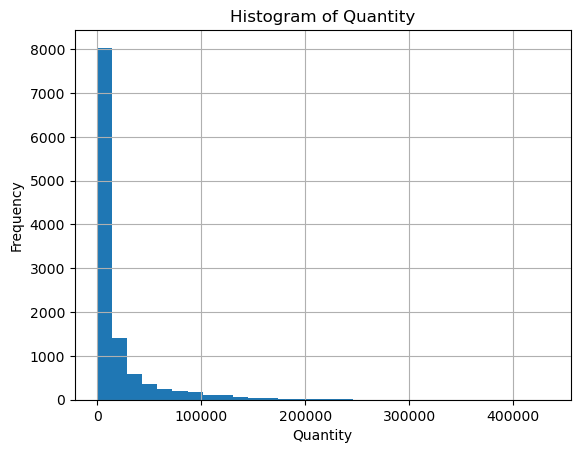

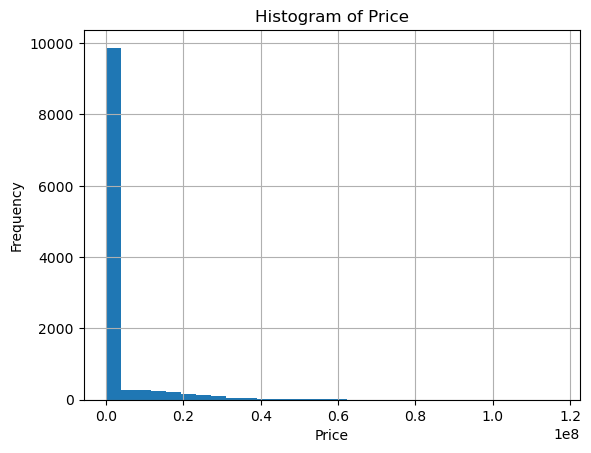

country
Belgium    2641
UK         2289
Germany    2281
France     2252
Italy      2020
Name: count, dtype: int64


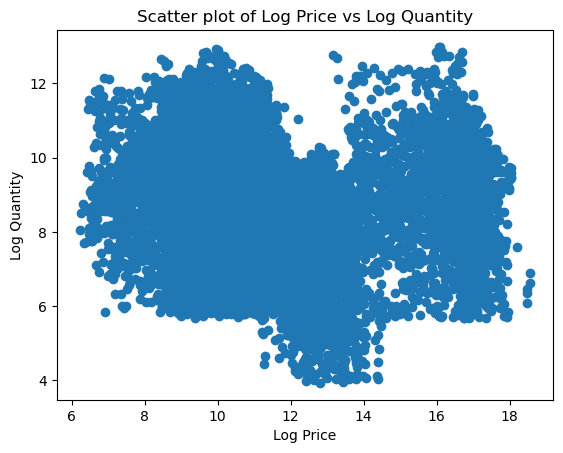

Correlation between log(price) and log(quantity):           lnp       lnq
lnp  1.000000 -0.135325
lnq -0.135325  1.000000


In [2]:
# Summary statistics for 'quantity' and 'price'
print(df[['qu', 'pr']].describe())

# Histogram of 'quantity'
df['qu'].hist(bins=30)
plt.title('Histogram of Quantity')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show()

# Histogram of 'price'
df['pr'].hist(bins=30)
plt.title('Histogram of Price')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

# Tabulate 'country'
print(df['country'].value_counts())

# Log transformations
df['lnq'] = np.log(df['qu'])
df['lnp'] = np.log(df['pr'])

# Scatter plot of log(price) vs log(quantity)
plt.scatter(df['lnp'], df['lnq'])
plt.title('Scatter plot of Log Price vs Log Quantity')
plt.xlabel('Log Price')
plt.ylabel('Log Quantity')
plt.show()

# Calculate and print correlation between log price and log quantity
print("Correlation between log(price) and log(quantity):", df[['lnp', 'lnq']].corr())

# (b) OLS-Fixed effects estimator of the standard logic model:

In [3]:
import statsmodels.formula.api as smf

# Construct market size, shares, and log-odds ratio
df['logpop'] = np.log(df['pop'])
df['loggdp'] = np.log(df['ngdp'])
df['msize'] = df['pop'] / 4
df['share'] = df['qu'] / df['msize']

# Calculate the outside goods market share
df['sum_share'] = df.groupby(['country', 'year'])['share'].transform('sum')
df['share0'] = 1 - df['sum_share']

# Generate log odds ratio
df['lsj_ls0'] = np.log(df['share'] / df['share0'])

# Run the fixed-effects OLS regression
fixed_effects_model = smf.ols(formula='lsj_ls0 ~ price + horsepower + fuel + width + domestic + height + weight + logpop + loggdp + C(country) + C(year) + C(brand)', data=df).fit(cov_type='HC3')

# Print regression results
print(fixed_effects_model.summary())

C:\Users\gmoor\AppData\Local\Temp\ipykernel_14212\2935626821.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['sum_share'] = df.groupby(['country', 'year'])['share'].transform('sum')


                            OLS Regression Results                            
Dep. Variable:                lsj_ls0   R-squared:                       0.574
Model:                            OLS   Adj. R-squared:                  0.571
Method:                 Least Squares   F-statistic:                     215.7
Date:                Mon, 30 Sep 2024   Prob (F-statistic):               0.00
Time:                        22:31:41   Log-Likelihood:                -16060.
No. Observations:               11483   AIC:                         3.228e+04
Df Residuals:                   11403   BIC:                         3.287e+04
Df Model:                          79                                         
Covariance Type:                  HC3                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

## (b) Interpretation: The OLS regression results indicate price, horsepower, fuel comsumption, and several other product characterisitcs signficantly impact the log-oods ration of market shares. The fixed effects for countries, years, and brands capture varations that are not directly explaiend by product characteristics. We can assume that higher prices reduce market share and domestics brands perform better. 

# (c) IV estimation of the standard logic model:

## [i]:

In [4]:
# Create the 'ones' column explicitly
df['ones'] = 1

# Group by country and year
group_cols = ['country', 'year']

# IV1 generation for each characteristic
df['numJ'] = df.groupby(group_cols)['ones'].transform('sum')

for col in ['horsepower', 'fuel', 'width', 'height', 'domestic', 'weight']:
    df[f'sum_{col}'] = df.groupby(group_cols)[col].transform('sum')
    df[f'IV1_{col}'] = df['numJ'] * df[col] - df[f'sum_{col}']
    df.drop(columns=[f'sum_{col}'], inplace=True)

# IV2 generation for each characteristic
for col in ['horsepower', 'fuel', 'width', 'height', 'domestic', 'weight']:
    df[f'mean_{col}'] = df.groupby(group_cols)[col].transform('mean')
    df[f'var_{col}'] = df.groupby(group_cols)[col].transform(lambda x: np.var(x, ddof=0))
    df[f'IV2_{col}'] = df['numJ'] * (df[col] - df[f'mean_{col}']) ** 2 + df['numJ'] * df[f'var_{col}']
    df.drop(columns=[f'mean_{col}', f'var_{col}'], inplace=True)

C:\Users\gmoor\AppData\Local\Temp\ipykernel_14212\2348775012.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df['numJ'] = df.groupby(group_cols)['ones'].transform('sum')
C:\Users\gmoor\AppData\Local\Temp\ipykernel_14212\2348775012.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  df[f'sum_{col}'] = df.groupby(group_cols)[col].transform('sum')
C:\Users\gmoor\AppData\Local\Temp\ipykernel_14212\2348775012.py:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the f

## [ii]:

In [5]:
from linearmodels.iv import IV2SLS

# Define the endogenous variable and instruments
endog = df['price']
exog = df[['horsepower', 'fuel', 'width', 'domestic', 'height', 'weight', 'logpop', 'loggdp']]
iv = df[['IV1_horsepower', 'IV1_fuel', 'IV1_width', 'IV1_domestic', 'IV1_height', 'IV1_weight',
         'IV2_horsepower', 'IV2_fuel', 'IV2_width', 'IV2_domestic', 'IV2_height', 'IV2_weight']]

# Run 2SLS
iv_model = IV2SLS(df['lsj_ls0'], exog, endog, iv).fit(cov_type='robust')

# Print IV regression results
print(iv_model.summary)

                          IV-2SLS Estimation Summary                          
Dep. Variable:                lsj_ls0   R-squared:                      0.9759
Estimator:                    IV-2SLS   Adj. R-squared:                 0.9759
No. Observations:               11483   F-statistic:                 4.739e+05
Date:                Mon, Sep 30 2024   P-value (F-stat)                0.0000
Time:                        22:31:41   Distribution:                  chi2(9)
Cov. Estimator:                robust                                         
                                                                              
                             Parameter Estimates                              
            Parameter  Std. Err.     T-stat    P-value    Lower CI    Upper CI
------------------------------------------------------------------------------
horsepower    -0.0403     0.0016    -24.631     0.0000     -0.0435     -0.0371
fuel          -0.1257     0.0090    -13.986     0.00

## (c) Interpretation: IV-2SLS regression results indicate that price does not significantly affect the logg-odds ratio of market shares, unlike the OLS regression results. Product characteristics like fuel efficincy, horsepower, width, and whether the product is dommestic or not are a critical role in determining the market share.

# (d) Willingness to pay (WTP) for fuel efficiency:

In [6]:
# Extract coefficients
alpha_price = iv_model.params['price']
beta_fuel = iv_model.params['fuel']

# Calculate WTP
wtp = -beta_fuel / alpha_price
print("WTP =", wtp)

WTP = 17.02297811927135


# (e) Price elasticity of demand:

In [7]:
# Calculate price elasticity for each observation
df['elasticity'] = -alpha_price * (1 - df['share']) * df['price']

# Summary statistics for elasticity
print(df['elasticity'].describe())

# Grouped summary by country
print(df.groupby('country')['elasticity'].describe())

count    11483.000000
mean        -0.136380
std          0.065894
min         -1.109948
25%         -0.167440
50%         -0.120858
75%         -0.090494
max         -0.038727
Name: elasticity, dtype: float64
          count      mean       std       min       25%       50%       75%  \
country                                                                       
Belgium  2641.0 -0.122916  0.057286 -0.584867 -0.148144 -0.108314 -0.080914   
France   2252.0 -0.126195  0.054265 -0.605196 -0.151067 -0.113383 -0.088205   
Germany  2281.0 -0.115675  0.047870 -0.434030 -0.139046 -0.102258 -0.081249   
Italy    2020.0 -0.139380  0.068858 -0.754498 -0.172105 -0.121909 -0.093703   
UK       2289.0 -0.179921  0.077428 -1.109948 -0.218538 -0.162612 -0.128583   

              max  
country            
Belgium -0.041893  
France  -0.044899  
Germany -0.042839  
Italy   -0.038727  
UK      -0.055180  


C:\Users\gmoor\AppData\Local\Temp\ipykernel_14212\3733935762.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  print(df.groupby('country')['elasticity'].describe())
